# Imports & common variables

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
import glob
%matplotlib inline

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, 'output_images')
test_dir = os.path.join(cwd, 'test_images')
challenge_dir = os.path.join(cwd, 'challenge_video_frames')
camera_cal = os.path.join(cwd, 'camera_cal')

checkerboard_shape = (9,6) #Number of coners surrounded by the images  
checkerboard_values = checkerboard_shape[0] * checkerboard_shape[1]
#checkerboard_shape_alt = (8,6)

In [3]:
camera_cal_images = glob.glob(os.path.join(camera_cal, '*.jpg'))
test_images = glob.glob(os.path.join(test_dir, '*.jpg'))
challenge_images = glob.glob(os.path.join(challenge_dir, '*.png'))

## Camera Calibration

In [4]:
objpoints = []
imgpoints = []

objp = np.zeros((9*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) #x ,y coordinates

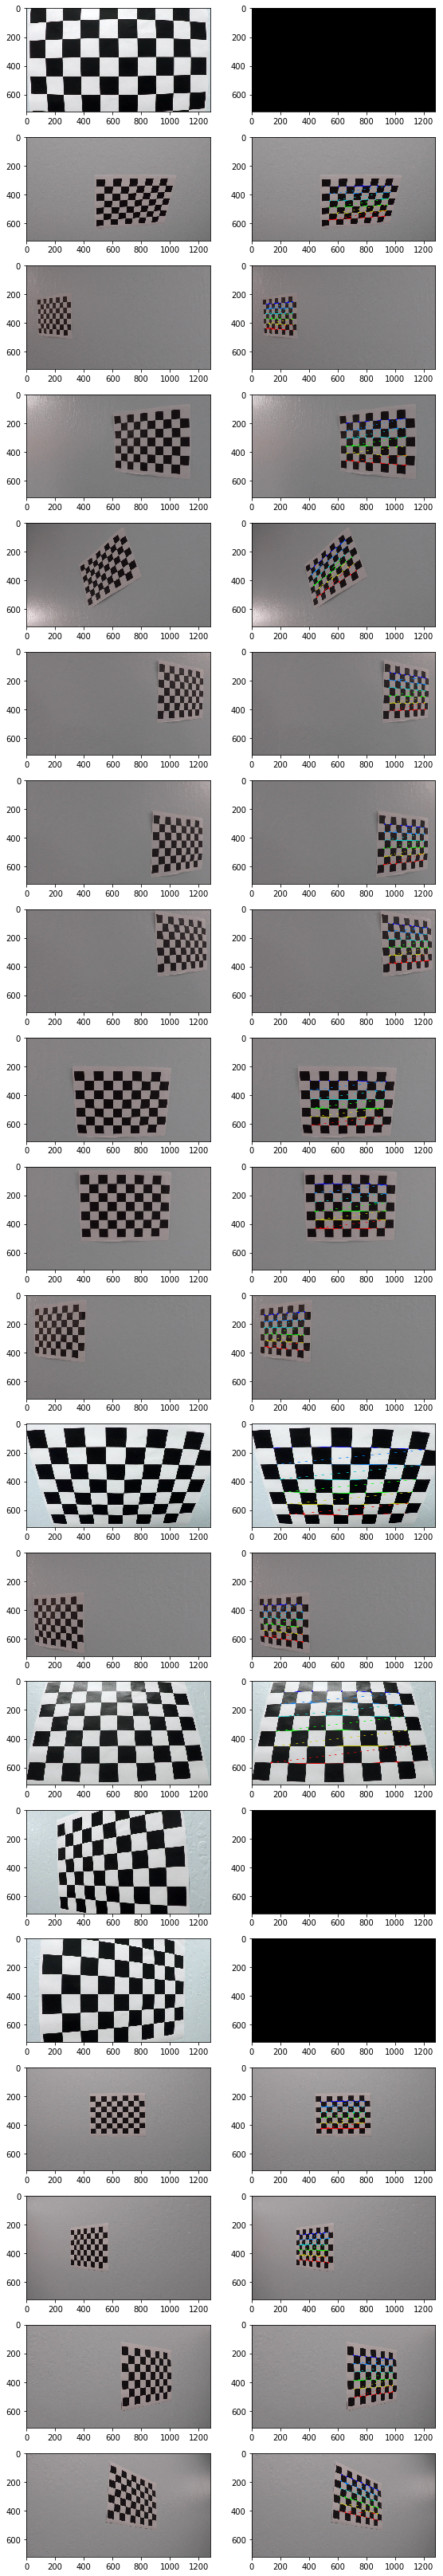

In [5]:
fig, axarr = plt.subplots(20, 2, figsize=(8, 45))
#fig.set_figheight(5)
#fig.set_figwidth(5)
fig.tight_layout()
subplots = iter(axarr)

i = 0
for filename in camera_cal_images:
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_shape, None)
    plot = next(subplots)
    plot[0].imshow(img)
    plot[0].autoscale(False)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        #Visualization
        line_img = np.copy(img)
        cv2.drawChessboardCorners(line_img, checkerboard_shape, corners, ret)
        plot[1].imshow(line_img)
        #plot[1].autoscale(False)
    else:
        plot[1].imshow(np.zeros_like(img))
        


In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

In [7]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

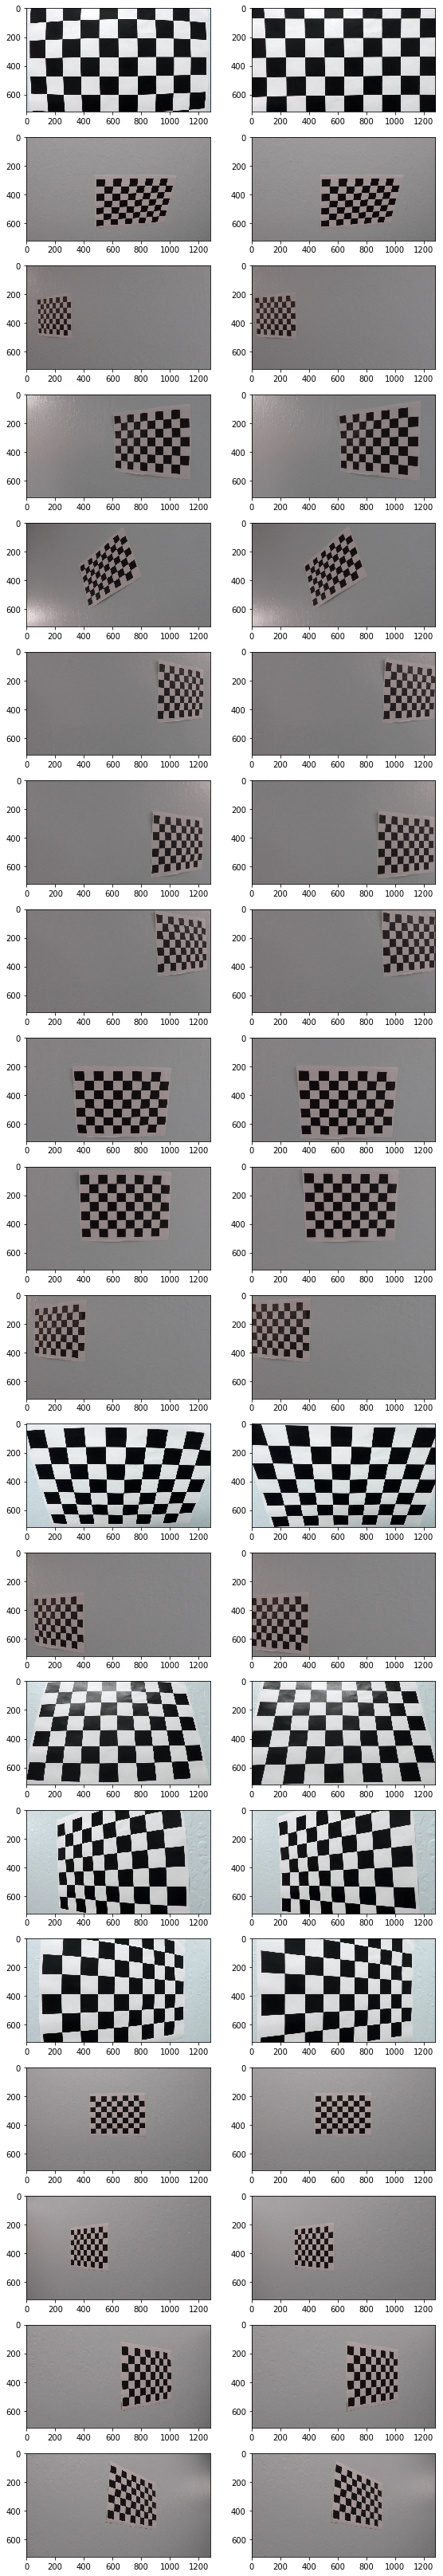

In [8]:
fig, axarr = plt.subplots(20, 2, figsize=(8, 45))
#fig.set_figheight(5)
#fig.set_figwidth(5)
fig.tight_layout()
subplots = iter(axarr)

for filename in camera_cal_images:
    img = cv2.imread(filename)
    dst = undistort(img)#, mtx, dist, None, mtx)
    plot = next(subplots)
    plot[0].imshow(img)
    plot[0].autoscale(False)
    plot[1].imshow(dst)
    plot[1].autoscale(False)


## Line detection

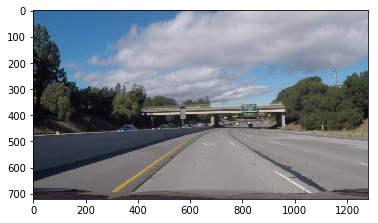

In [9]:
test_img = cv2.imread(challenge_images[4])[:,:,::-1]
plt.imshow(test_img[:,:,::-1])

### Other Color Spaces

#### HLS
S channel works well on the right & left line, except for the shadow

L channel is very bright for right lines.

We can use both

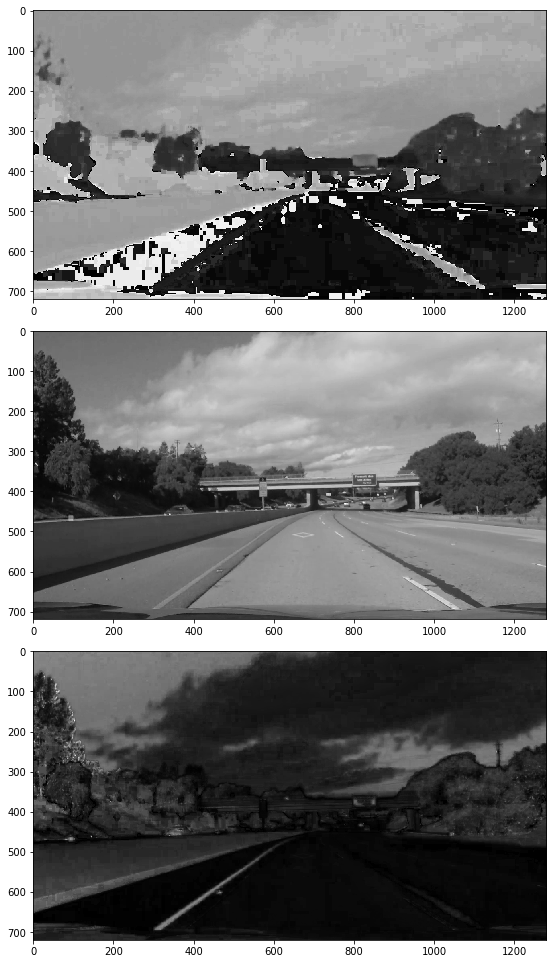

In [10]:
hls = cv2.cvtColor(test_img, cv2.COLOR_BGR2HLS)
#plt.imshow(test_img[:,:,::-1])
fig, axarr = plt.subplots(3, 1, figsize=(8, 13.5))
fig.tight_layout()

for i in range(3):
    axarr[i].imshow((hls[:,:,i]), cmap='gray')
    

#### HSV

V channel is useable, but not particularly active so it might be noisy

S channel does not appear sufficiently different to S in HLS

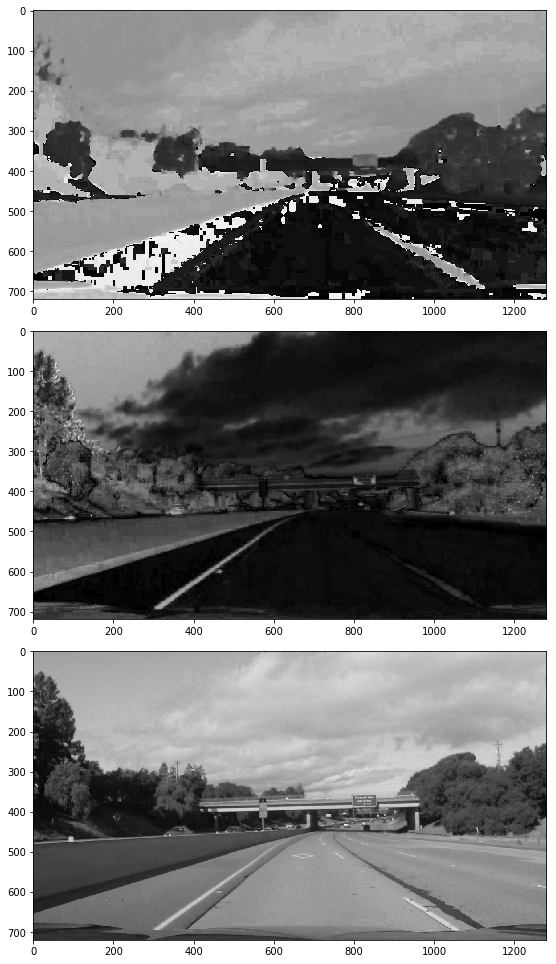

In [11]:
hsv = cv2.cvtColor(test_img, cv2.COLOR_BGR2HSV)
#plt.imshow(test_img[:,:,::-1])
fig, axarr = plt.subplots(3, 1, figsize=(8, 13.5))
fig.tight_layout()

for i in range(3):
    axarr[i].imshow((hsv[:,:,i]), cmap='gray')

#### LAB

The B channel (blue–yellow) handles the left side image well

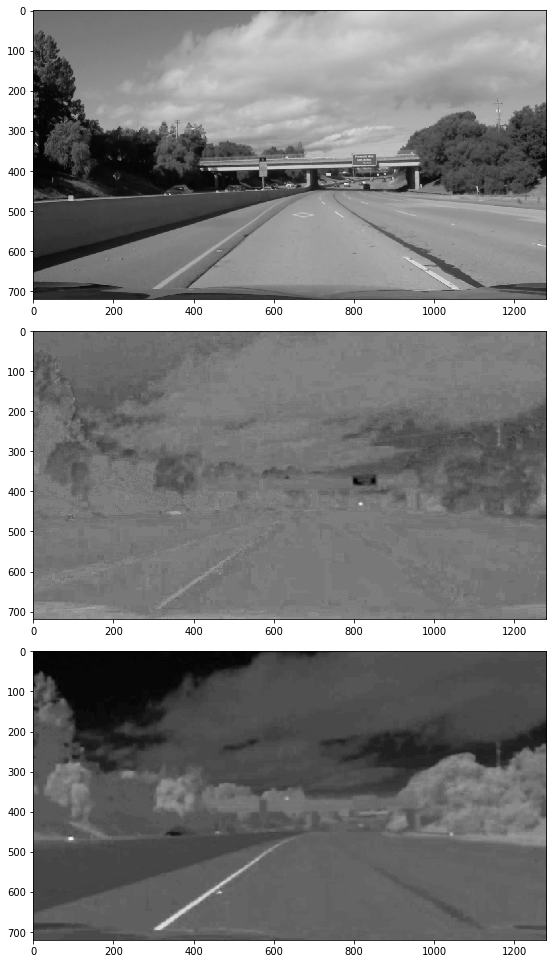

In [12]:
hls = cv2.cvtColor(test_img, cv2.COLOR_BGR2LAB)
#plt.imshow(test_img[:,:,::-1])
fig, axarr = plt.subplots(3, 1, figsize=(8, 13.5))
fig.tight_layout()

for i in range(3):
    axarr[i].imshow(hls[:,:,i], cmap='gray')

#### LUV

V is the best channel for this color space, but U is close

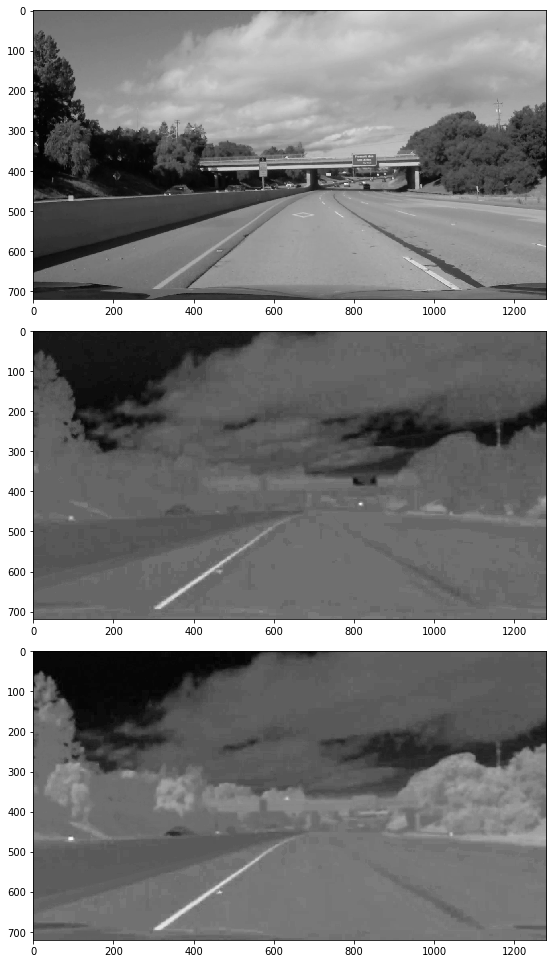

In [13]:
luv = cv2.cvtColor(test_img, cv2.COLOR_BGR2LUV)
#plt.imshow(test_img[:,:,::-1])
fig, axarr = plt.subplots(3, 1, figsize=(8, 13.5))
fig.tight_layout()

for i in range(3):
    axarr[i].imshow(luv[:,:,i], cmap='gray')

#### Plain RGB

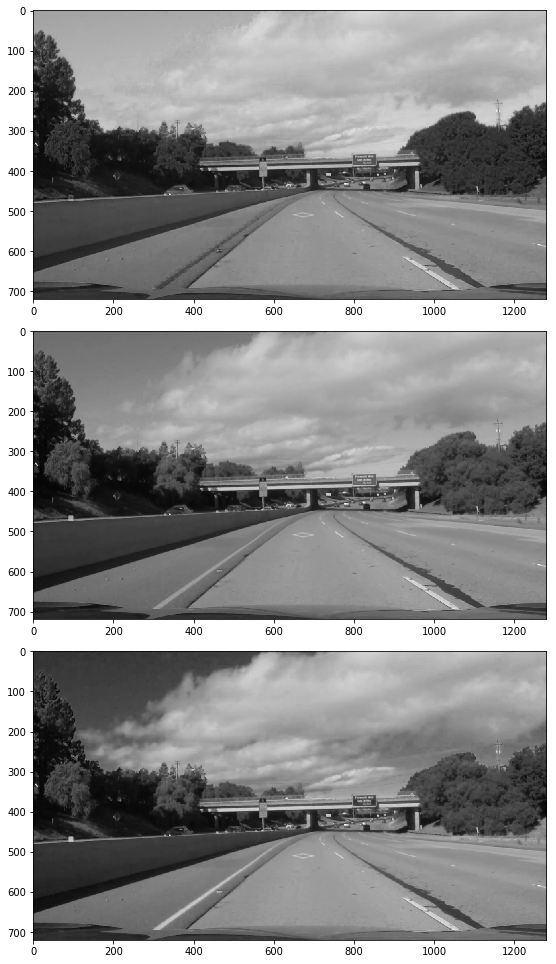

In [14]:
#luv = cv2.cvtColor(test_img, cv2.COLOR_BGR2LUV)
#plt.imshow(test_img[:,:,::-1])
fig, axarr = plt.subplots(3, 1, figsize=(8, 13.5))
fig.tight_layout()

for i in range(3):
    axarr[i].imshow(test_img[:,:,i], cmap='gray')

In [15]:
def dir_threshold(gray, sobel_kernel=5, thresh=(0, np.pi/2)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    direc = np.arctan2(sobely, sobelx)
    #dir = np.array((mag/np.max(mag)) * 255, dtype=np.uint8)
    mask = (direc > thresh[0]) & (direc < thresh[1])
    float_output = np.zeros_like(direc)
    float_output[mask] = 1
    binary_output = (((float_output)/np.max(float_output)) * 255).astype(np.uint8)
    return binary_output

def abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(0, 255)):
    assert(orient == 'x' or orient == 'y')
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient == 'x' , orient == 'y', ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    sobel = np.array((abs_sobel/np.max(abs_sobel)) * 255, dtype=np.uint8)
    binary_output = np.zeros_like(sobel, dtype=np.uint8)
    binary_output[((sobel > thresh[0]) & (sobel < thresh[1]))] = 1
    return binary_output

def mag_thresh(gray, sobel_kernel=5, mag_thresh=(0, 255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    mag = np.sqrt(sobelx**2 + sobely**2)
    mag = np.array((mag/np.max(mag)) * 255, dtype=np.uint8)#np.array((mag/np.max(mag)) * 255, dtype=np.uint8)

    mask = (mag > mag_thresh[0]) & (mag < mag_thresh[1])
    binary_output = np.zeros_like(mag)
    binary_output[mask] = 1

    return binary_output

In [16]:
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [17]:
ksize = 5

gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(0, 255))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(0, 255))
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(0, 255))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.0, np.pi/2))


In [18]:
hls = cv2.cvtColor(test_img, cv2.COLOR_BGR2HLS)
hsv = cv2.cvtColor(test_img, cv2.COLOR_BGR2HSV)
lab = cv2.cvtColor(test_img, cv2.COLOR_BGR2LAB)
luv = cv2.cvtColor(test_img, cv2.COLOR_BGR2LUV)
l = hls[:,:,1]
s = hls[:,:,2]
v = hsv[:,:,2]
v2 = luv[:,:,2]
b = lab[:,:,2]

gray = test_img[:,:,2]  #cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
#test_small = cv2.resize(hls[:,:,2], (0,0), fx=0.5, fy=0.5)

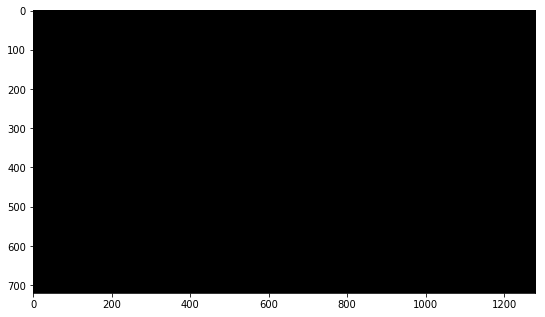

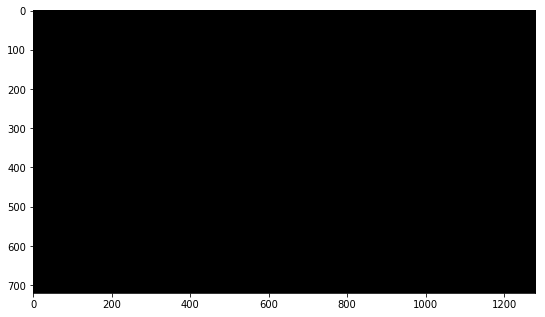

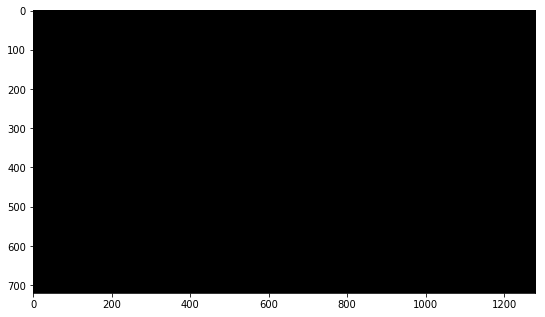

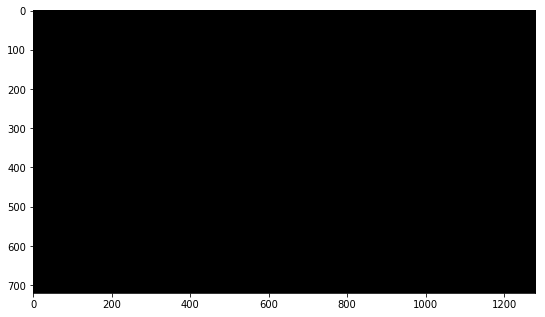

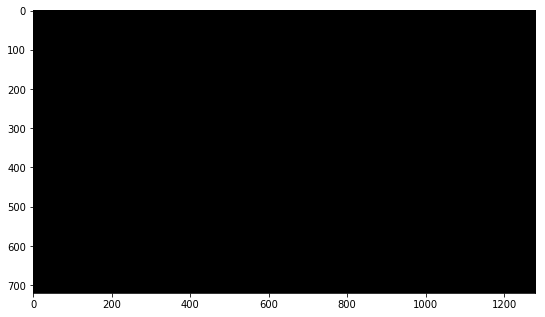

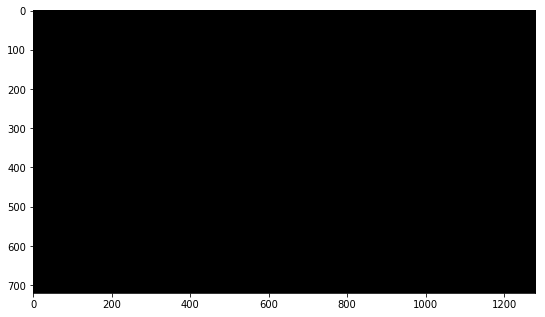

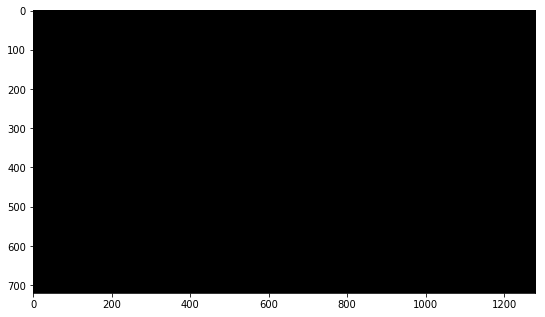

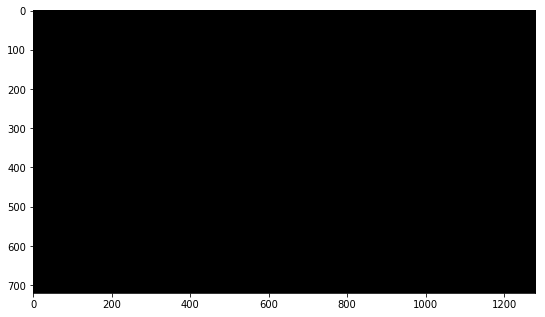

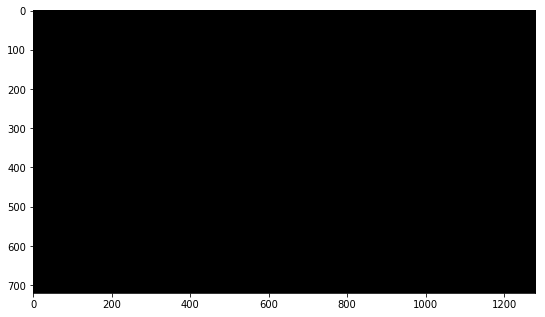

In [19]:
gradx = np.ones(gray.shape, dtype=np.uint8)
masked = np.ones(gray.shape, dtype=np.uint8)
grady = np.ones(gray.shape, dtype=np.uint8)
mag_binary = np.ones(gray.shape, dtype=np.uint8)
dir_binary = np.ones(gray.shape, dtype=np.uint8)
s_binary = np.zeros(gray.shape, dtype=np.uint8)
l_binary = np.zeros(gray.shape, dtype=np.uint8)
v_binary = np.zeros(gray.shape, dtype=np.uint8)
v2_binary = np.zeros(gray.shape, dtype=np.uint8)
b_binary = np.zeros(gray.shape, dtype=np.uint8)

def show():
    global gray
    gray = s_binary | l_binary | v_binary | b_binary | v2_binary # | (gradx & grady & mag_binary & dir_binary)
    #print(np.sum(masked))
    plt.figure(figsize=(9,16))
    plt.imshow(gray, cmap='gray')

def calc_gradx(gx_thresh):
    global gradx 
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=gx_thresh)
    show()
    
def calc_grady(gy_thresh):
    global grady 
    grady = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=gy_thresh)
    show()
    
def calc_mag(mg_thresh):
    global mag_binary 
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=mg_thresh)
    show()
    
def calc_dir(dir_thresh):
    global dir_binary 
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=dir_thresh)
    show()

def calc_s(s_thresh):
    global s_binary
    s_binary = np.zeros_like(s_binary)
    mask = ((s > s_thresh[0]) & (s < s_thresh[1]))
    print(np.sum(mask))
    s_binary[mask] = 1
    show()
    
def calc_v(v_thresh):
    global v_binary
    v_binary = np.zeros_like(v_binary)
    mask = ((v > v_thresh[0]) & (v < v_thresh[1]))
    print(np.sum(mask))
    v_binary[mask] = 1
    show()
    
def calc_v2(v2_thresh):
    global v2_binary
    v2_binary = np.zeros_like(v2_binary)
    mask = ((v2 > v2_thresh[0]) & (v2 < v2_thresh[1]))
    print(np.sum(mask))
    v2_binary[mask] = 1
    show()

def calc_l(l_thresh):
    global l_binary
    l_binary = np.zeros_like(l_binary)
    mask = ((l > l_thresh[0]) & (l < l_thresh[1]))
    print(np.sum(mask))
    l_binary[mask] = 1
    show()    

def calc_b(b_thresh):
    global b_binary
    b_binary = np.zeros_like(b_binary)
    mask = ((b > b_thresh[0]) & (b < b_thresh[1]))
    print(np.sum(mask))
    b_binary[mask] = 1
    show()
    
interact(calc_gradx, gx_thresh=widgets.IntRangeSlider(min=-1,max=256,step=1,value=(256,256), continuous_update=False));
interact(calc_grady, gy_thresh=widgets.IntRangeSlider(min=-1,max=256,step=1,value=(256,256), continuous_update=False));
interact(calc_mag, mg_thresh=widgets.IntRangeSlider(min=-1,max=256,step=1,value=(256,256), continuous_update=False));
interact(calc_s, s_thresh=widgets.IntRangeSlider(min=-1,max=256,step=1,value=(256,256), continuous_update=False));
interact(calc_v, v_thresh=widgets.IntRangeSlider(min=-1,max=256,step=1,value=(256,256), continuous_update=False));
interact(calc_v2, v2_thresh=widgets.IntRangeSlider(min=-1,max=256,step=1,value=(256,256), continuous_update=False));
interact(calc_l, l_thresh=widgets.IntRangeSlider(min=-1,max=256,step=1,value=(256,256), continuous_update=False));
interact(calc_b, b_thresh=widgets.IntRangeSlider(min=-1,max=256,step=1,value=(256,256), continuous_update=False));
interact(calc_dir, dir_thresh=widgets.FloatRangeSlider(min=-np.pi/2,max=np.pi/2,step=0.05,value=(-np.pi/2, np.pi/2), continuous_update=False));

In [20]:
gx_thresh = (0, 256)
gy_thresh = (0, 256)
mg_thresh = (30, 256)
dir_thresh = (0.0, 1.58)
s_thresh = (100, 256)
v1_thresh = (220, 256)
v2_thresh = (200, 256)
b_thresh = (150, 256)
r_thresh = (220, 256)
l_thresh = (210, 256)

#debugging ranges, not all black
#gx_thresh = (0, 255)
#gy_thresh = (0, 255)
#mg_thresh = (0, 255)
#dir_thresh = (0.0, 1.50)

def binary_activate_frame(img):
    #img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    #img[:,:,1] = cv2.equalizeHist(img[:,:,1])
    #img[:,:,2] = cv2.equalizeHist(img[:,:,2])
    
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(np.float)
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV).astype(np.float)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float)
    s = hsv[:,:,1]
    v1 = hsv[:,:,2]
    v2 = luv[:,:,2]
    b = lab[:,:,2]
    r = img[:,:,2]
    l = hls[:,:,1]
    
    s_mask = np.zeros_like(s).astype(np.uint8)
    v1_mask = np.zeros_like(v1).astype(np.uint8)
    #v2_mask = np.zeros_like(v2).astype(np.uint8)
    b_mask = np.zeros_like(b).astype(np.uint8)
    r_mask = np.zeros_like(r).astype(np.uint8)
    l_mask = np.zeros_like(l).astype(np.uint8)
    
    s_mask[((s > s_thresh[0]) & (s < s_thresh[1]))] = 1 
    v1_mask[((v1 > v1_thresh[0]) & (v1 < v1_thresh[1]))] = 1 
    #v2_mask[((v2 > v2_thresh[0]) & (v2 < v2_thresh[1]))] = 1 
    b_mask[((b > b_thresh[0]) & (b < b_thresh[1]))] = 1 
    r_mask[((r > r_thresh[0]) & (r < r_thresh[1]))] = 1
    l_mask[((l > l_thresh[0]) & (l < l_thresh[1]))] = 1
    
    mask = v1_mask | b_mask | s_mask | r_mask | l_mask
    
    gradx = abs_sobel_thresh(mask, orient='x', sobel_kernel=ksize, thresh=gx_thresh)
    grady = abs_sobel_thresh(mask, orient='y', sobel_kernel=ksize, thresh=gy_thresh)
    mag_binary = mag_thresh(mask, sobel_kernel=ksize, mag_thresh=mg_thresh)
    dir_binary = dir_threshold(mask, sobel_kernel=ksize, thresh=dir_thresh)
    
    return (gradx & grady & mag_binary & dir_binary)

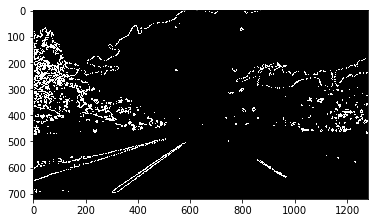

In [45]:
test_img = cv2.imread(challenge_images[0])
binary_activate_frame(test_img)
plt.imshow(binary_activate_frame(test_img),  cmap='gray')

## Perspective shift

In [22]:
print(test_img.shape)

(720, 1280, 3)


In [23]:
pts = np.int32([[200, 680], [560, 450], [720, 450], [1100, 680]])
color = (0,255,0)

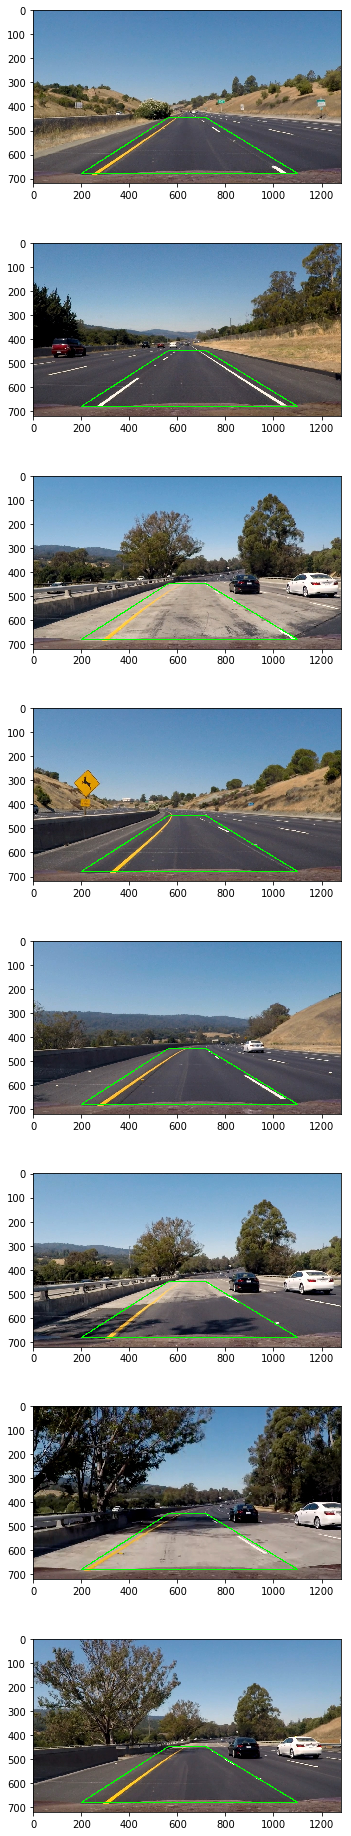

In [24]:

fig, axarr = plt.subplots(len(test_images), 1, figsize=(5, 26))
fig.tight_layout()
subplots = iter(axarr)

for filepath in test_images:
    img = cv2.imread(filepath)
    boxed_img = cv2.polylines(img, [pts], True, color=color, thickness=3)
    plot = next(subplots)
    plot.imshow(boxed_img[:,:,::-1])
    

In [46]:
src = pts.astype(np.float32)
xoffset = 150
yoffset = 0

x_size = 1280
y_size = 720
print(x_size, y_size)

image_size = (x_size, y_size)
dst = np.array([[xoffset, y_size - yoffset], [xoffset, yoffset], [x_size - xoffset, yoffset], [x_size - xoffset, y_size - yoffset]], dtype=np.float32)
M = cv2.getPerspectiveTransform(src, dst)

def skew_frame(img):
    warped = cv2.warpPerspective(img, M, image_size)
    return warped, M

1280 720


In [26]:
print(image_size)

(1130, 720)


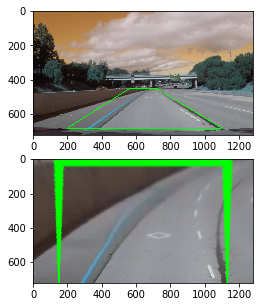

In [47]:
fig, axarr = plt.subplots(2, 1, figsize=(5, 5))

boxed = cv2.polylines(test_img, [pts], True, color=color, thickness=3)

skewed, M = skew_frame(boxed[:,:,::-1])
axarr[0].imshow(test_img[:,:,::-1])
axarr[1].imshow(skewed)

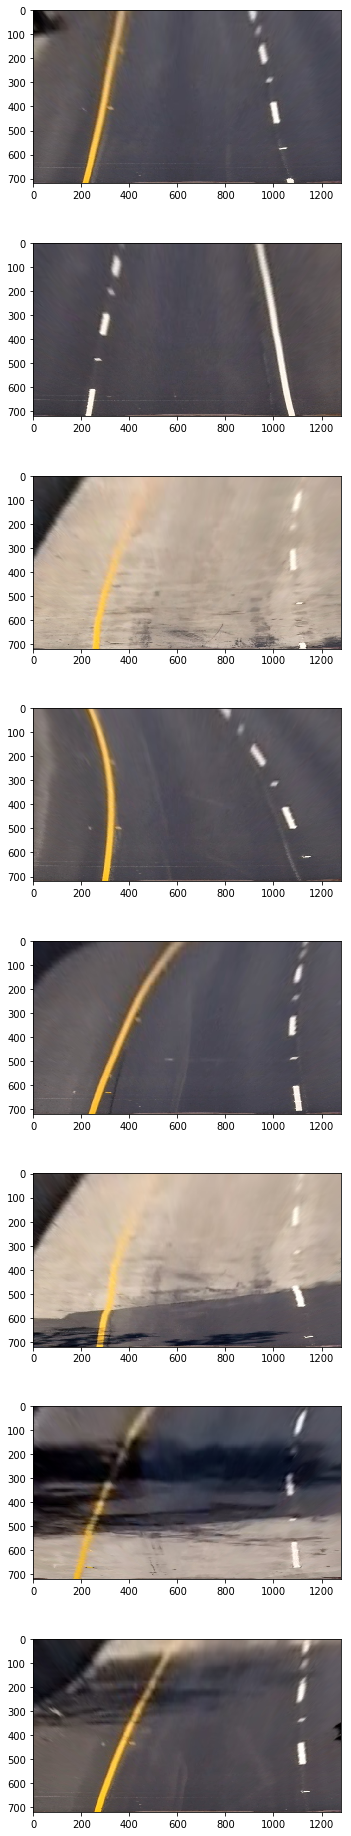

In [48]:
fig, axarr = plt.subplots(len(test_images), 1, figsize=(5, 26))
fig.tight_layout()
subplots = iter(axarr)

for filepath in test_images:
    img = cv2.imread(filepath)
    img = img[:,:,:] # red channel
    skewed, M = skew_frame(img)
    #boxed_img = cv2.polylines(img, [pts], True, color=color, thickness=3)
    plot = next(subplots)
    plot.imshow(skewed[:,:,::-1])

In [49]:
def augment_frame(frame):
    frame_orig = frame
    frame = undistort(frame)
    frame = binary_activate_frame(frame)
    frame, M = skew_frame(frame)
    #plt.imshow(frame)  
    #plt.imshow(frame, cmap='gray')
    return frame, M

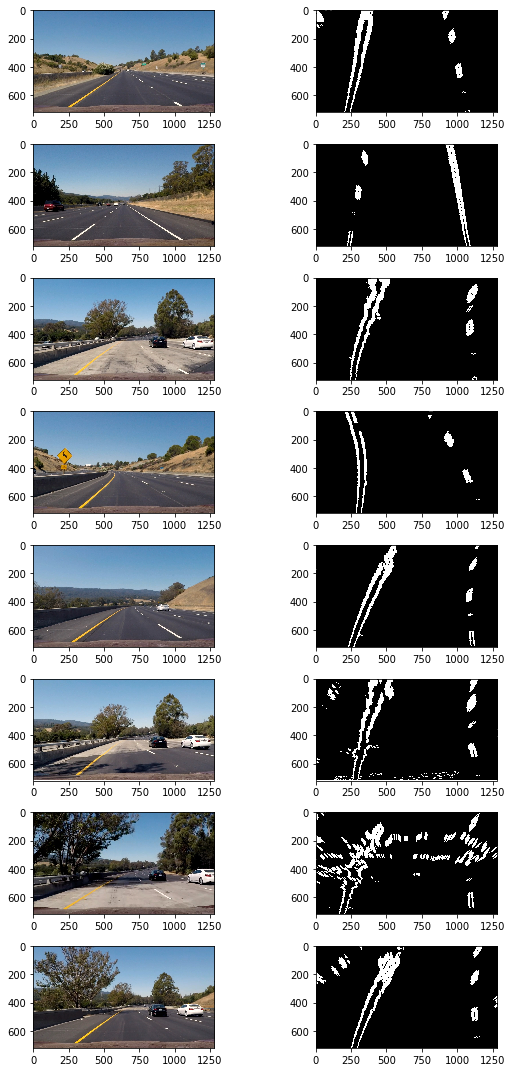

In [50]:
fig, axarr = plt.subplots(len(test_images), 2, figsize=(8, 15))
fig.tight_layout()
subplots = iter(axarr)

#print(undistort(test_img))
#plt.imshow(augment_frame(test_img)[0])
#print(test_img.shape)

for filepath in test_images:
    img = cv2.imread(filepath)
    skewed, M = augment_frame(img)
    plot = next(subplots)
    plot[0].imshow(img[:,:,::-1])
    plot[1].imshow(skewed, cmap='gray')

## Window search

In [31]:
window_width = 160 #8 windows wide
window_height = 80 #9 windows tall


In [32]:
#this is the lane finding algorithm just turned into a function call
def lane_finding(binary_warped, debug = False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #print(out_img.shape)
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        color=(0,255,0), thickness=2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        color=(0,255,0), thickness=2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if debug: # Visualizing
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        y_eval = np.max(ploty)

        #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        
        # Fit new polynomials to x,y in world space
        print(ploty.shape)
        print(leftx.shape)
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm')
        # Example values: 632.1 m    626.2 m
    
    return left_fit, right_fit
        

(720,)
(36343,)
2490.6026144 m 2134.0231568 m


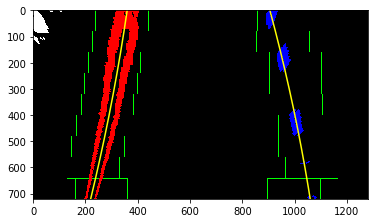

In [52]:
test_img = cv2.imread(test_images[0])
aug_img, M = augment_frame(test_img)
left_fit, right_fit = lane_finding(aug_img, True)

## Drawing

In [34]:
def draw_lane(warped, img, Minv, left_fit, right_fit):
    #Recalculate lines locally
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

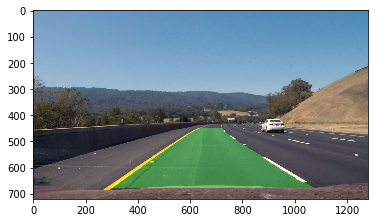

In [53]:
test_img = cv2.imread(test_images[4])
warped, M_ = augment_frame(test_img)
left_fit, right_fit = lane_finding(warped)
Minv = np.linalg.inv(M_)
lane_test = draw_lane(warped, test_img, Minv, left_fit, right_fit)
plt.imshow(lane_test[:,:,::-1])

In [36]:
prev_left_curve = []
prev_right_curve = []
M_history = []

In [37]:
def process_frame(frame):
    #Exponential decay of history
    global prev_left_curve
    global prev_left_curve
    global prev_right_curve
    global M_history
    
    warped, M_ = augment_frame(frame)
    M_history.append(M_)
    left_fit, right_fit = lane_finding(warped)
    if prev_left_curve:
        left_fit = (left_fit + prev_left_curve)/2
        prev_left_curve = left_fit
    if prev_right_curve:
        right_fit = (right_fit + prev_righ_curve)/2
        prev_right_curve = right_fit
    Minv = np.linalg.inv(M)
    output = draw_lane(warped, frame, Minv, left_fit, right_fit)
    return output

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
frame_count = 0
def save_frame(frame):
    global frame_count
    import os
    out_dir = os.path.join(os.getcwd(), './challenge_video_frames/{0:0>3}.png').format(frame_count)
    print(out_dir)
    cv2.imwrite(out_dir, frame)
    frame_count += 1
    return frame

In [40]:
import os
print(os.path.join(os.getcwd(), 'abc'))

/Users/pcalderw/Workspace/SelfDrivingCar/Term1/CarND-Advanced-Lane-Lines/abc


In [54]:
video_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,50)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1250/1251 [10:02<00:00,  2.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 7min 26s, sys: 2min 42s, total: 10min 8s
Wall time: 10min 4s


In [ ]:
video_output = 'challenge_video_out.mp4'
clip1 = VideoFileClip("challenge_video.mp4").subclip(1,3)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(video_output, audio=False)

In [ ]:
video_output = 'harder_challenge_video_out.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,47)
white_clip = clip1.fl_image(save_frames)
%time white_clip.write_videofile(video_output, audio=False)

In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))